In [160]:
import sys
import os

# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list, numerical
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
from isca_tools.convection.base import lcl_metpy, convection_neutral_profile, dry_profile_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity, opd_lw_gray
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier_analytic, get_temp_fourier_numerical, get_temp_extrema_analytic,\
    get_temp_extrema_numerical
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from scipy import optimize, ndimage
import cftime
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [44]:
exp_dir = 'sqe_profile/column/'
exp_name = ['day150']
# Get low level sigma level
namelist = isca_tools.load_namelist(exp_dir+exp_name[0])
sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')
sigma_near_surf = sigma_levels_full[-1]

ds = isca_tools.load_dataset(exp_dir + exp_name[0], decode_times=True).isel(lon=0, lat=0)
ds = ds.load()

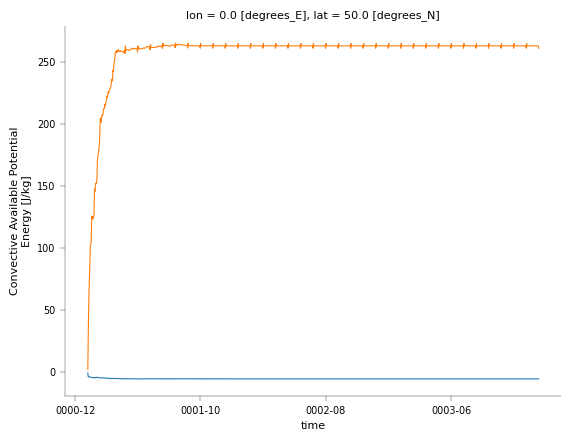

In [38]:
ds.cin.plot()
ds.cape.plot()

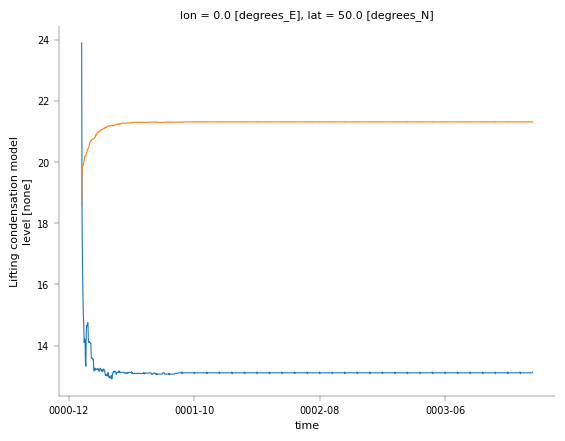

In [40]:
ds.klzbs.plot()
ds.klcls.plot()

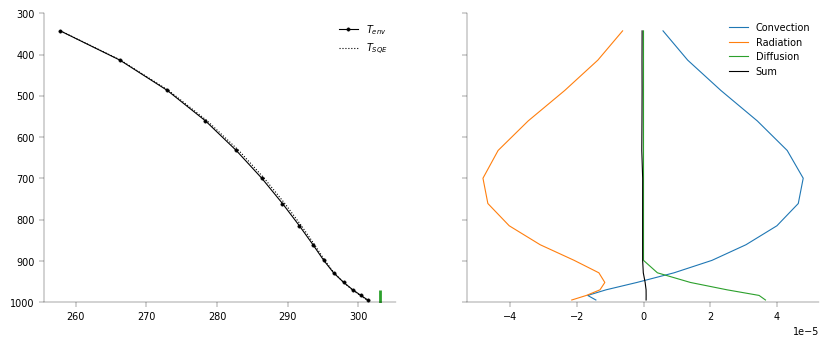

In [192]:
ds_use = ds.isel(time=-1).sel(pfull=slice(300, 1000))
fig, ax = plt.subplots(1, 2, sharey=True)
isca_tools.plot.fig_resize(fig, 10)
ax[0].plot(ds_use.temp, ds_use.pfull, color='k', marker='o', label='$T_{env}$')
ax[0].plot(ds_use.t_ref, ds_use.pfull, linestyle=':', color='k', label='$T_{SQE}$')
ax[0].scatter(ds_use.t_surf, 1000, color='C2', marker='|', s=300, lw=2)
ax[0].invert_yaxis()
ax[1].plot(ds_use.dt_tg_convection, ds_use.pfull, color='C0', label='Convection')
ax[1].plot(ds_use.tdt_rad, ds_use.pfull, color='C1', label='Radiation')
# ax[1].plot(ds_use.tdt_solar, ds_use.pfull, color='C1', linestyle=':', label='Radiation (just solar)')
ax[1].plot(ds_use.dt_tg_diffusion, ds_use.pfull, color='C2', label='Diffusion')
ax[1].plot(ds_use.dt_tg_diffusion + ds_use.tdt_rad + ds_use.dt_tg_convection, ds_use.pfull, color='k', label='Sum')
ax[0].set_ylim(1000, 300)
ax[0].legend()
ax[1].legend()
plt.show()

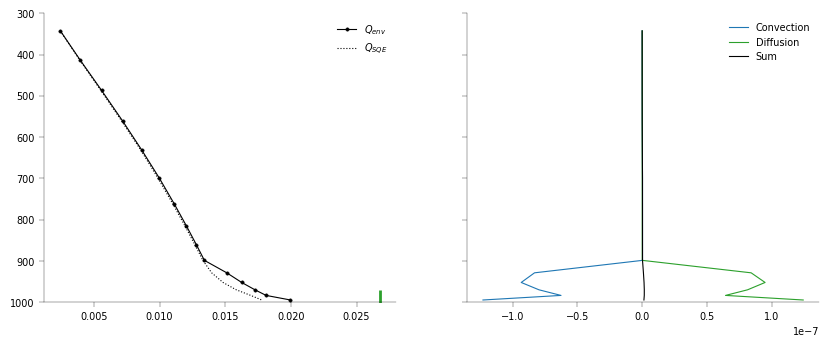

In [112]:
fig, ax = plt.subplots(1, 2, sharey=True)
isca_tools.plot.fig_resize(fig, 10)
ax[0].plot(ds_use.sphum, ds_use.pfull, color='k', marker='o', label='$Q_{env}$')
ax[0].plot(ds_use.q_ref, ds_use.pfull, linestyle=':', color='k', label='$Q_{SQE}$')
ax[0].scatter(sphum_sat(ds_use.t_surf, 1000*100), 1000, color='C2', marker='|', s=300, lw=2)
# ax[0].scatter(ds_use.sphum_2m, 1000, color='C2', marker='|', s=300, lw=2)
ax[0].invert_yaxis()
ax[1].plot(ds_use.dt_qg_convection, ds_use.pfull, color='C0', label='Convection')
ax[1].plot(ds_use.dt_qg_diffusion, ds_use.pfull, color='C2', label='Diffusion')
ax[1].plot(ds_use.dt_qg_diffusion + ds_use.dt_qg_convection, ds_use.pfull, color='k', label='Sum')
ax[0].set_ylim(1000, 300)
ax[0].legend()
ax[1].legend()
plt.show()

In [118]:
ds_hourly = isca_tools.load_dataset(exp_dir + exp_name[0]+'_hourly', decode_times=True).isel(lon=0, lat=0)
ds_hourly = ds_hourly.load()

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 36 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')


In [182]:
ds_use = ds_hourly.where(ds_hourly.time.dt.day == 25, drop=True).sel(pfull=slice(300, 1000))

In [183]:
def apply_func_vec(func, p, *args):
    # Must p be the last argument of func. p is the pressure levels in Pa, where desire to get temperature
    return xr.apply_ufunc(func, *args, p, input_core_dims=[[]] * len(args) + [['pfull']],
                          output_core_dims=[['pfull']], vectorize=True, dask='parallelized', output_dtypes=[float])

def conv_neutral_profile(temp_lcl, p_lcl, p):
    # if np.isnan(temp_lcl):
    #     return temp_lcl * p # if not land return numpy array of nans of same length as p
    # Follows dry adiabat below LCL and moist adiabat above it
    temp_profile = moist_profile(float(temp_lcl), float(p_lcl), p)
    temp_profile[p>=p_lcl] = dry_profile_temp(float(temp_lcl), float(p_lcl), p[p>=p_lcl])
    return temp_profile

In [184]:
p_lcl, temp_lcl = lcl_metpy(ds_use.temp_2m, ds_use.sphum_2m, ds_use.ps)
temp_sqe = apply_func_vec(conv_neutral_profile, ds.pfull*100, temp_lcl, p_lcl)

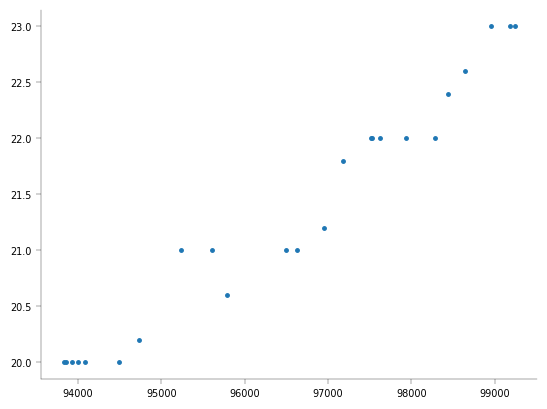

In [187]:
plt.scatter(p_lcl, ds_use.klcls)

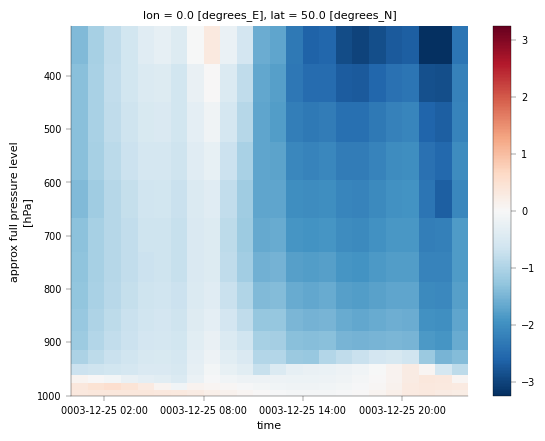

In [185]:
(ds_use.temp-temp_sqe).transpose().plot()
plt.gca().invert_yaxis()

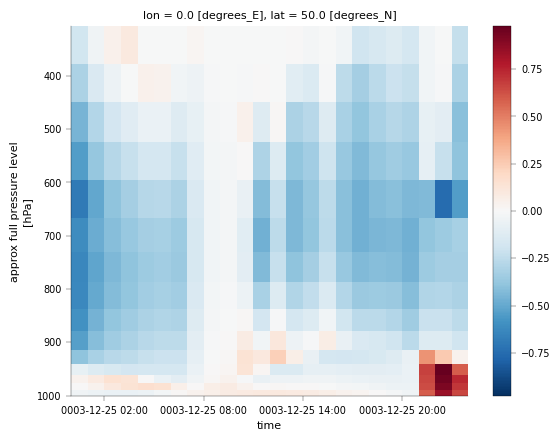

In [186]:
(ds_use.temp-ds_use.t_ref).transpose().plot()
plt.gca().invert_yaxis()

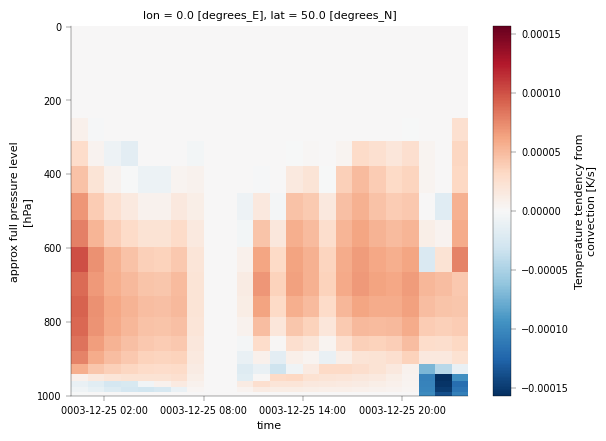

In [147]:
ds_use.dt_tg_convection.transpose().plot()
plt.gca().invert_yaxis()

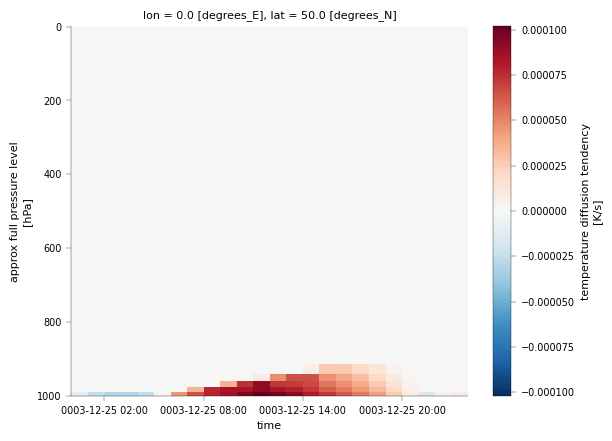

In [148]:
ds_use.dt_tg_diffusion.transpose().plot()
plt.gca().invert_yaxis()

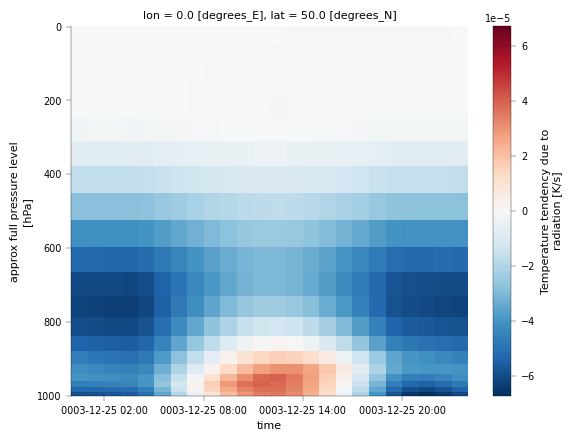

In [150]:
ds_use.tdt_rad.transpose().plot()
plt.gca().invert_yaxis()

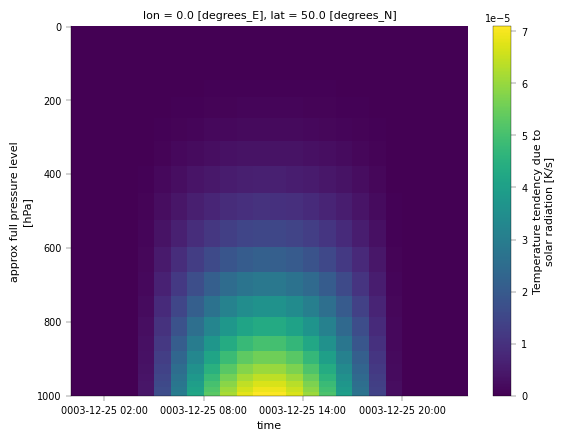

In [151]:
ds_use.tdt_solar.transpose().plot()
plt.gca().invert_yaxis()

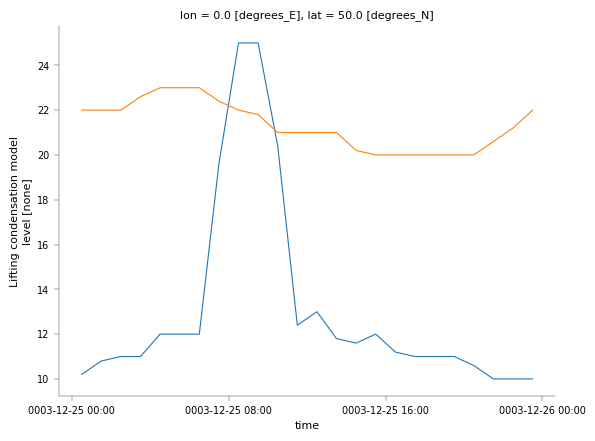

In [152]:
ds_use.klzbs.plot()
ds_use.klcls.plot()

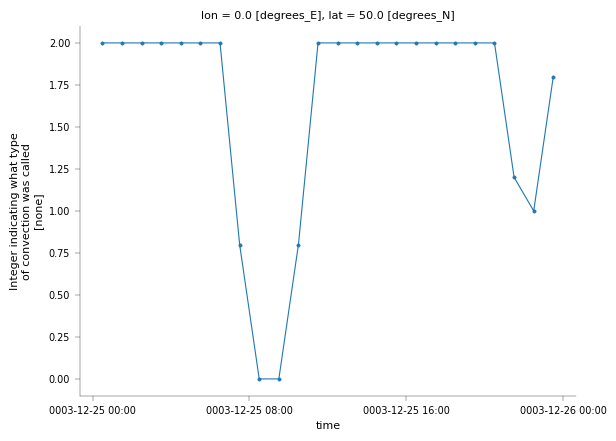

In [157]:
ds_use.convflag.plot(marker='o')

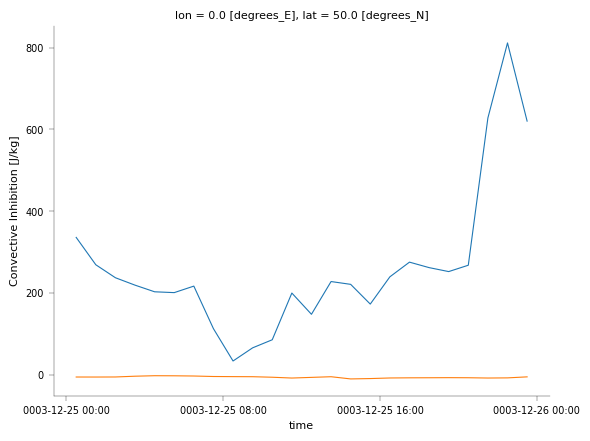

In [154]:
ds_use.cape.plot()
ds_use.cin.plot()